In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Scikit-learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    roc_curve,
    roc_auc_score,
)
from sklearn.inspection import PartialDependenceDisplay, partial_dependence


In [2]:
data = pd.read_excel("mapped_data_Final.xlsx")
data.head()
data.shape

(2804, 29)

Now we count each class to see if we have class imbalance. From the data it is appearent that by far the most represented class is 2 = More productive. A naive benchmark would be to classify all records as the most prohiminent class and would yiled an accuracy of 58,09%

In [3]:
# Count of each class
class_counts = data['productivity_remote_vs_office'].value_counts()

# Percentage of each class
class_percentages = data['productivity_remote_vs_office'].value_counts(normalize=True) * 100

# Display the result
class_distribution = pd.DataFrame({
    'Count': class_counts,
    'Percentage (%)': class_percentages
})

print(class_distribution)


                               Count  Percentage (%)
productivity_remote_vs_office                       
2                               1646       58.701854
1                                716       25.534950
0                                442       15.763195


## Tuning

We then train a Random Forest. To determine what are the best hyperparameters we use Random Search (as it is computationally less expensive) with 30 iterations for 5 fold cross validation.

In [4]:
# Step 1: Prepare features (X) and target (y)
X = data.drop(columns=['productivity_remote_vs_office'])
y = data['productivity_remote_vs_office']

# Step 2: Encode categorical features using LabelEncoder or pd.get_dummies
# We'll use get_dummies to handle multiple categories
X = pd.get_dummies(X, drop_first=True)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Define the parameter distribution for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_leaf': range(4, 11),
    'max_features': ['sqrt', 'log2']
}

# Step 5: Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Step 6: Set up RandomizedSearchCV for Random Forest
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=30, 
    scoring='accuracy',  
    cv=5, 
    random_state=42,
    n_jobs=-1
)

# Step 7: Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Step 8: Get the best model from random search
best_rf_model = random_search.best_estimator_

# Step 9: Make predictions on the test set
y_test_pred = best_rf_model.predict(X_test)
y_train_pred = best_rf_model.predict(X_train)

print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'n_estimators': 100, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 40}


In [5]:
# Step 10: Calculate training and validation accuracy
training_accuracy = accuracy_score(y_train, y_train_pred)
validation_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

# Step 11: Evaluate the model using confusion matrix and classification report
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Validation):")
print(classification_report(y_test, y_test_pred))

# Additional Metrics
# Mean Absolute Error (MAE) - Measures the average deviation between actual and predicted categories
mae = mean_absolute_error(y_test, y_test_pred)
print(f"\nMean Absolute Error (MAE): {mae:.2f}")

# Ordinal Accuracy: The percentage of predictions that are off by no more than one category
tolerant_accuracy = sum(abs(y_test - y_test_pred) <= 1) / len(y_test)
print(f"\nOrdinal Accuracy (Off-by-One): {tolerant_accuracy * 100:.2f}%")

Training Accuracy: 77.42%
Validation Accuracy: 60.69%

Confusion Matrix (Validation):
[[ 21   9 118]
 [  8  13 184]
 [  5   7 477]]

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.62      0.14      0.23       148
           1       0.45      0.06      0.11       205
           2       0.61      0.98      0.75       489

    accuracy                           0.61       842
   macro avg       0.56      0.39      0.36       842
weighted avg       0.57      0.61      0.50       842


Mean Absolute Error (MAE): 0.54

Ordinal Accuracy (Off-by-One): 85.39%


## ROC

In [6]:
#Binarize the output for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Assuming classes are labeled as 0, 1, 2
n_classes = y_test_binarized.shape[1]

# Get predicted probabilities for each class
y_test_proba = best_rf_model.predict_proba(X_test)

#Calculate ROC curve and ROC AUC score for each class
fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}

# Create a dictionary to store ROC data for exporting
roc_data = {}

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_binarized[:, i], y_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_test_proba[:, i])
    
    # Print AUC score and ROC curve values
    print(f"Class {i} - ROC AUC Score: {roc_auc[i]}")
    print(f"Class {i} - False Positive Rates: {fpr[i]}")
    print(f"Class {i} - True Positive Rates: {tpr[i]}")
    print(f"Class {i} - Thresholds: {thresholds[i]}")
    
    # Store data for export
    roc_data[f'Class_{i}_fpr'] = pd.Series(fpr[i])
    roc_data[f'Class_{i}_tpr'] = pd.Series(tpr[i])
    roc_data[f'Class_{i}_thresholds'] = pd.Series(thresholds[i])

Class 0 - ROC AUC Score: 0.7313458992133344
Class 0 - False Positive Rates: [0.         0.         0.         0.00144092 0.00144092 0.00432277
 0.00432277 0.00864553 0.00864553 0.01152738 0.01152738 0.0129683
 0.0129683  0.02017291 0.02017291 0.02161383 0.02161383 0.02305476
 0.02305476 0.02449568 0.02449568 0.02737752 0.02737752 0.03025937
 0.03025937 0.03314121 0.03314121 0.03602305 0.03602305 0.03746398
 0.03746398 0.04610951 0.04610951 0.04755043 0.04755043 0.05475504
 0.05475504 0.06340058 0.06340058 0.0648415  0.0648415  0.06772334
 0.06772334 0.07925072 0.07925072 0.08069164 0.08069164 0.08357349
 0.08357349 0.08501441 0.08501441 0.08789625 0.08789625 0.09798271
 0.09798271 0.10230548 0.10230548 0.10662824 0.10662824 0.11815562
 0.11815562 0.12536023 0.12536023 0.13544669 0.13544669 0.13832853
 0.13832853 0.15850144 0.15850144 0.17435159 0.17435159 0.17579251
 0.17579251 0.18011527 0.18011527 0.18876081 0.18876081 0.19020173
 0.19020173 0.19308357 0.19308357 0.1945245  0.1945245

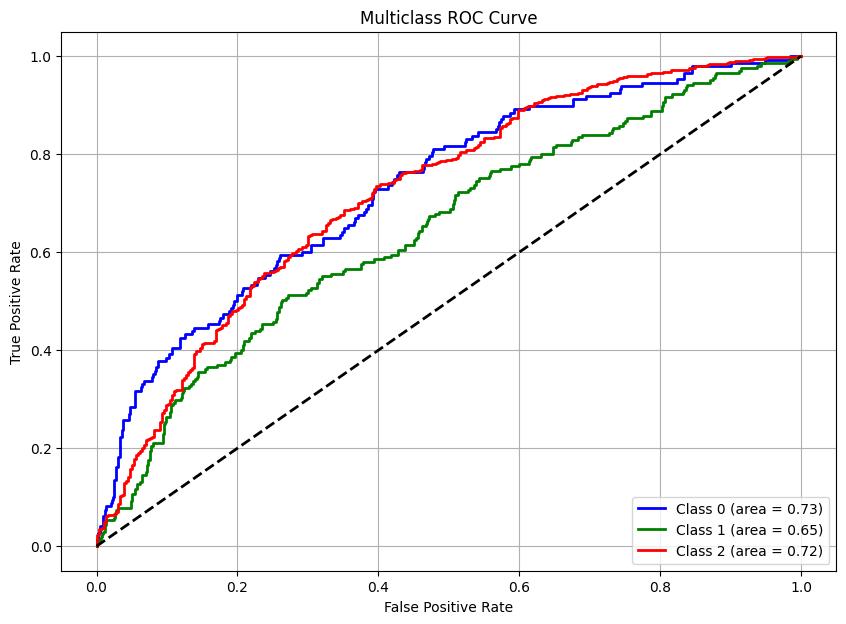

In [7]:
# Plotting the ROC curves for each class
plt.figure(figsize=(10, 7))
colors = cycle(['blue', 'green', 'red'])  # Different color for each class

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

# Plot the diagonal line for reference (random chance)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Feature Importance

Top 10 Most Important Features:
                                   Feature  Importance
11          preferred_rw_percentage_future    0.073116
10            preferred_rw_percentage_2020    0.069843
23                                     age    0.067876
20                    remote_hours_working    0.052805
15               inperson_hours__commuting    0.045249
9                    rw_collaboration_easy    0.044105
4                       rw_percentage_2020    0.043295
17    inperson_hours__personal_family_time    0.042101
21       remote_hours_personal_family_time    0.039343
22  remote_hours_domestic_responsibilities    0.038347


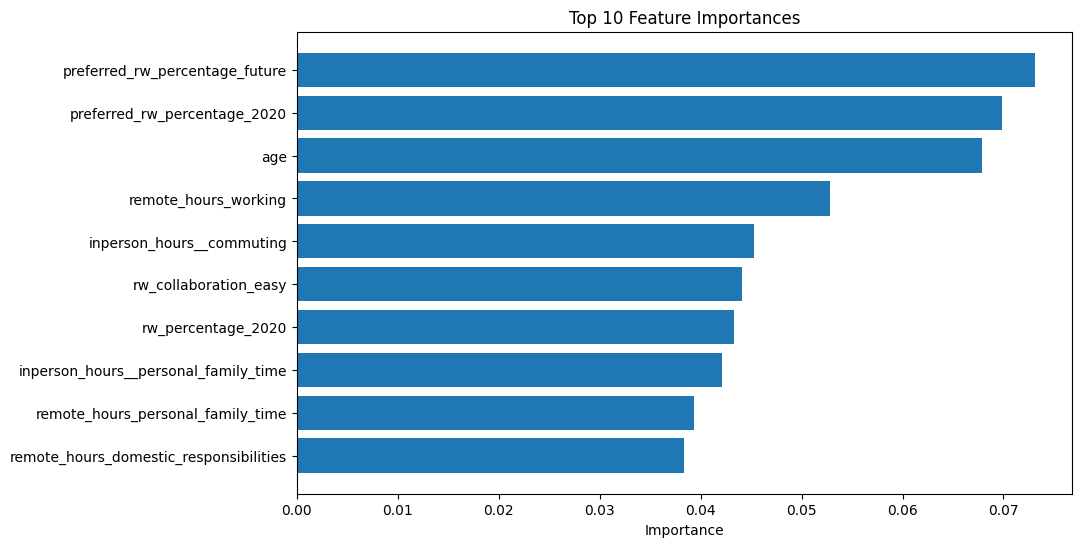

In [8]:
# Feature importance from Random Forest
if hasattr(best_rf_model, 'feature_importances_'):
    feature_importances = best_rf_model.feature_importances_

    # Create a DataFrame to hold feature names and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Display the top 10 most important features
    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance")
    plt.show()

# Partial Dependence Plots

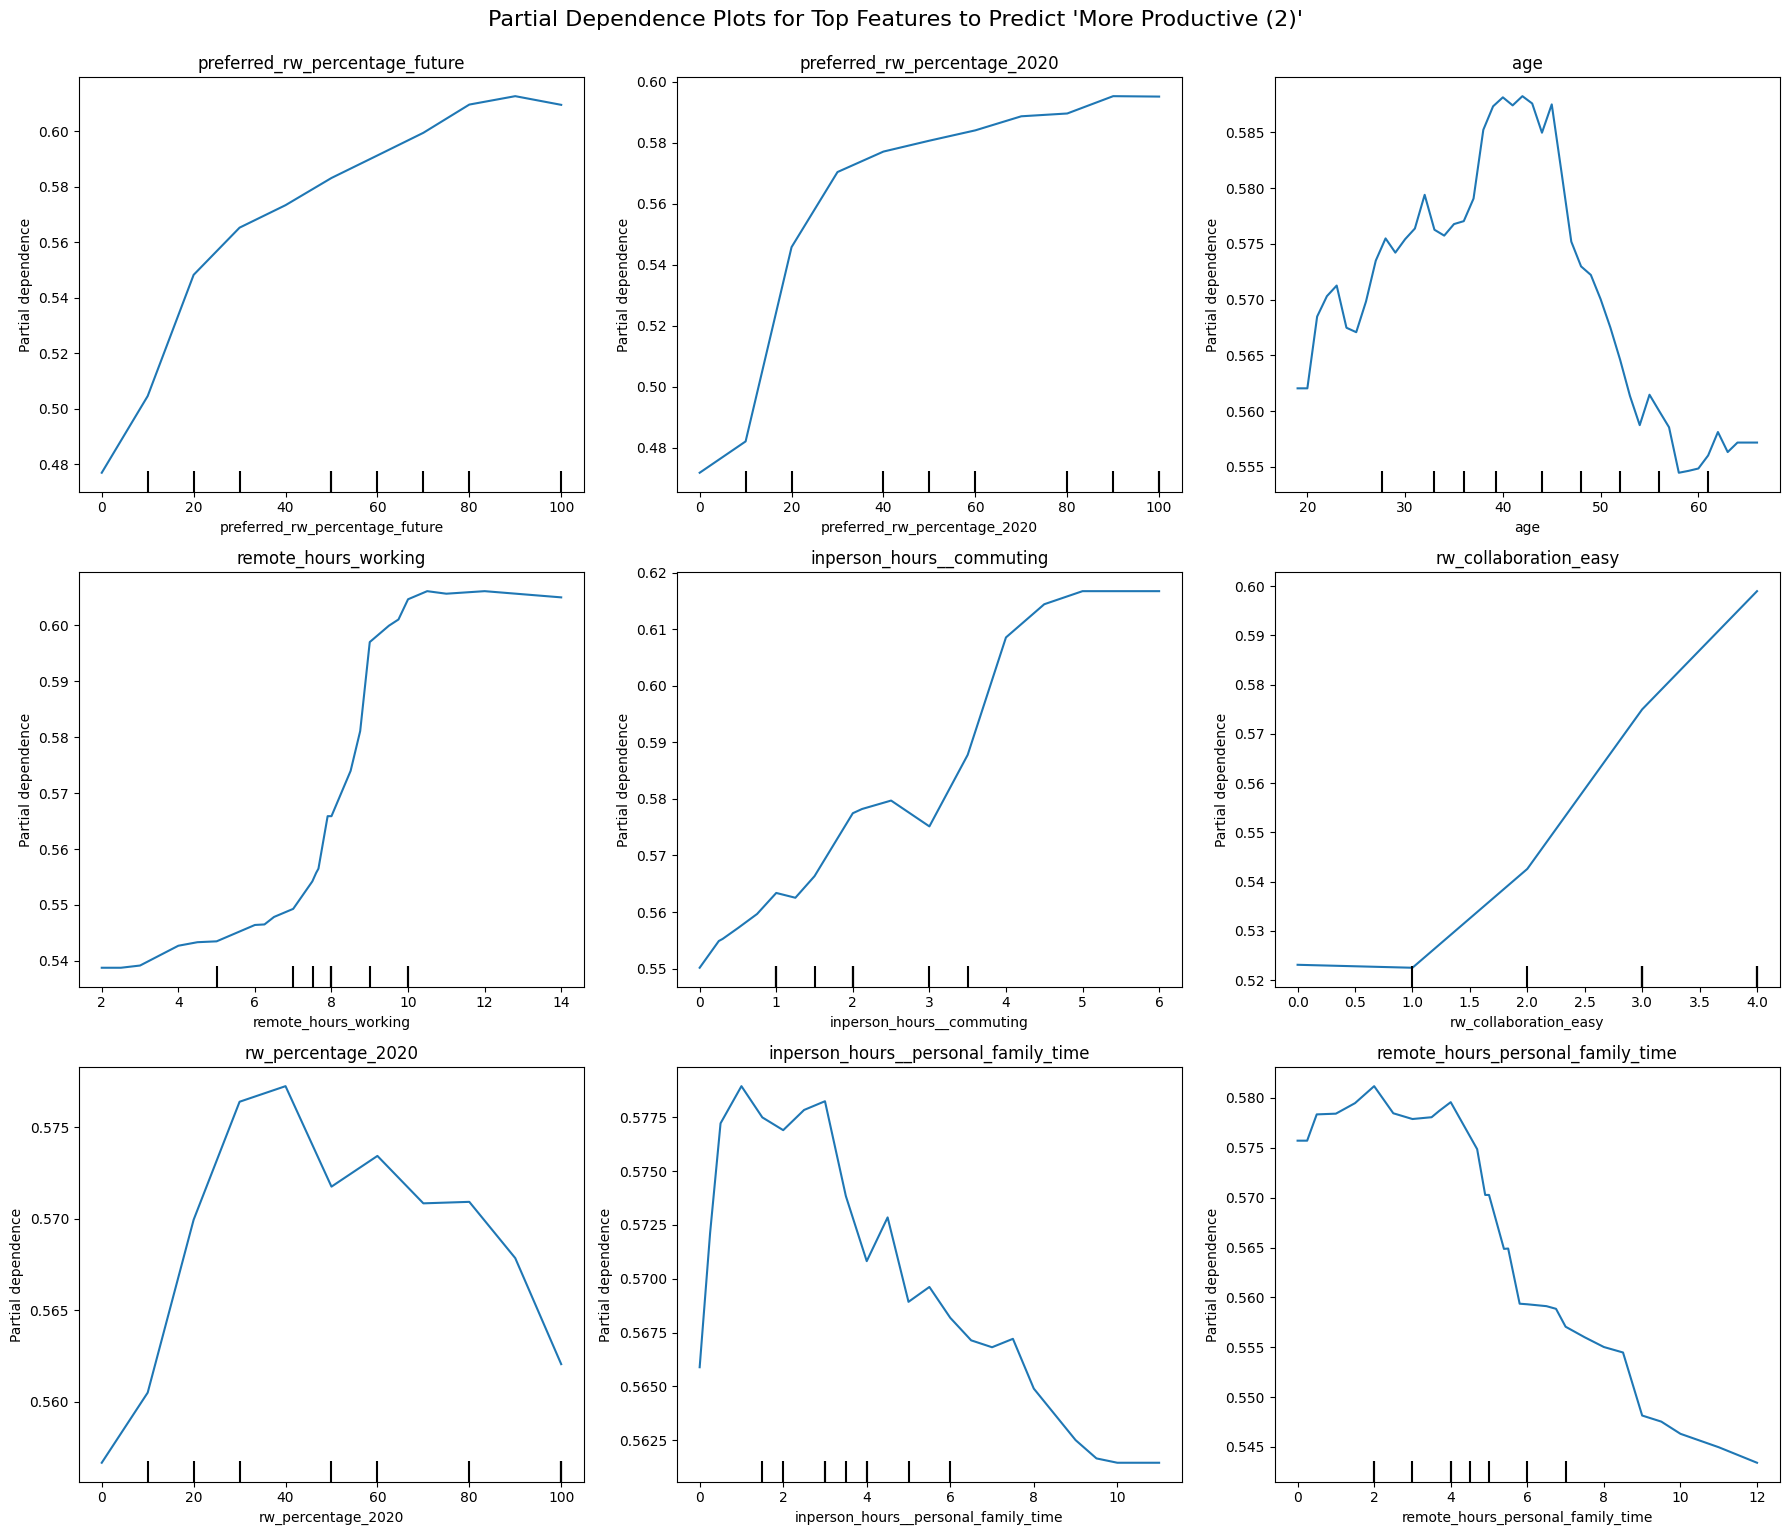

In [9]:
#Set the target class. 2 = More Productive
target_class = 2

# List of top features to analyze
top_features = feature_importance_df['Feature'][:9]

# Create a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Generate Partial Dependence Display for each feature in the grid
for idx, feature in enumerate(top_features):
    row, col = divmod(idx, 3)
    PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_test,
        features=[feature],
        target=target_class,
        ax=axes[row, col],
    )
    axes[row, col].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.suptitle("Partial Dependence Plots for Top Features to Predict 'More Productive (2)'", y=1.02, fontsize=16)
plt.show()

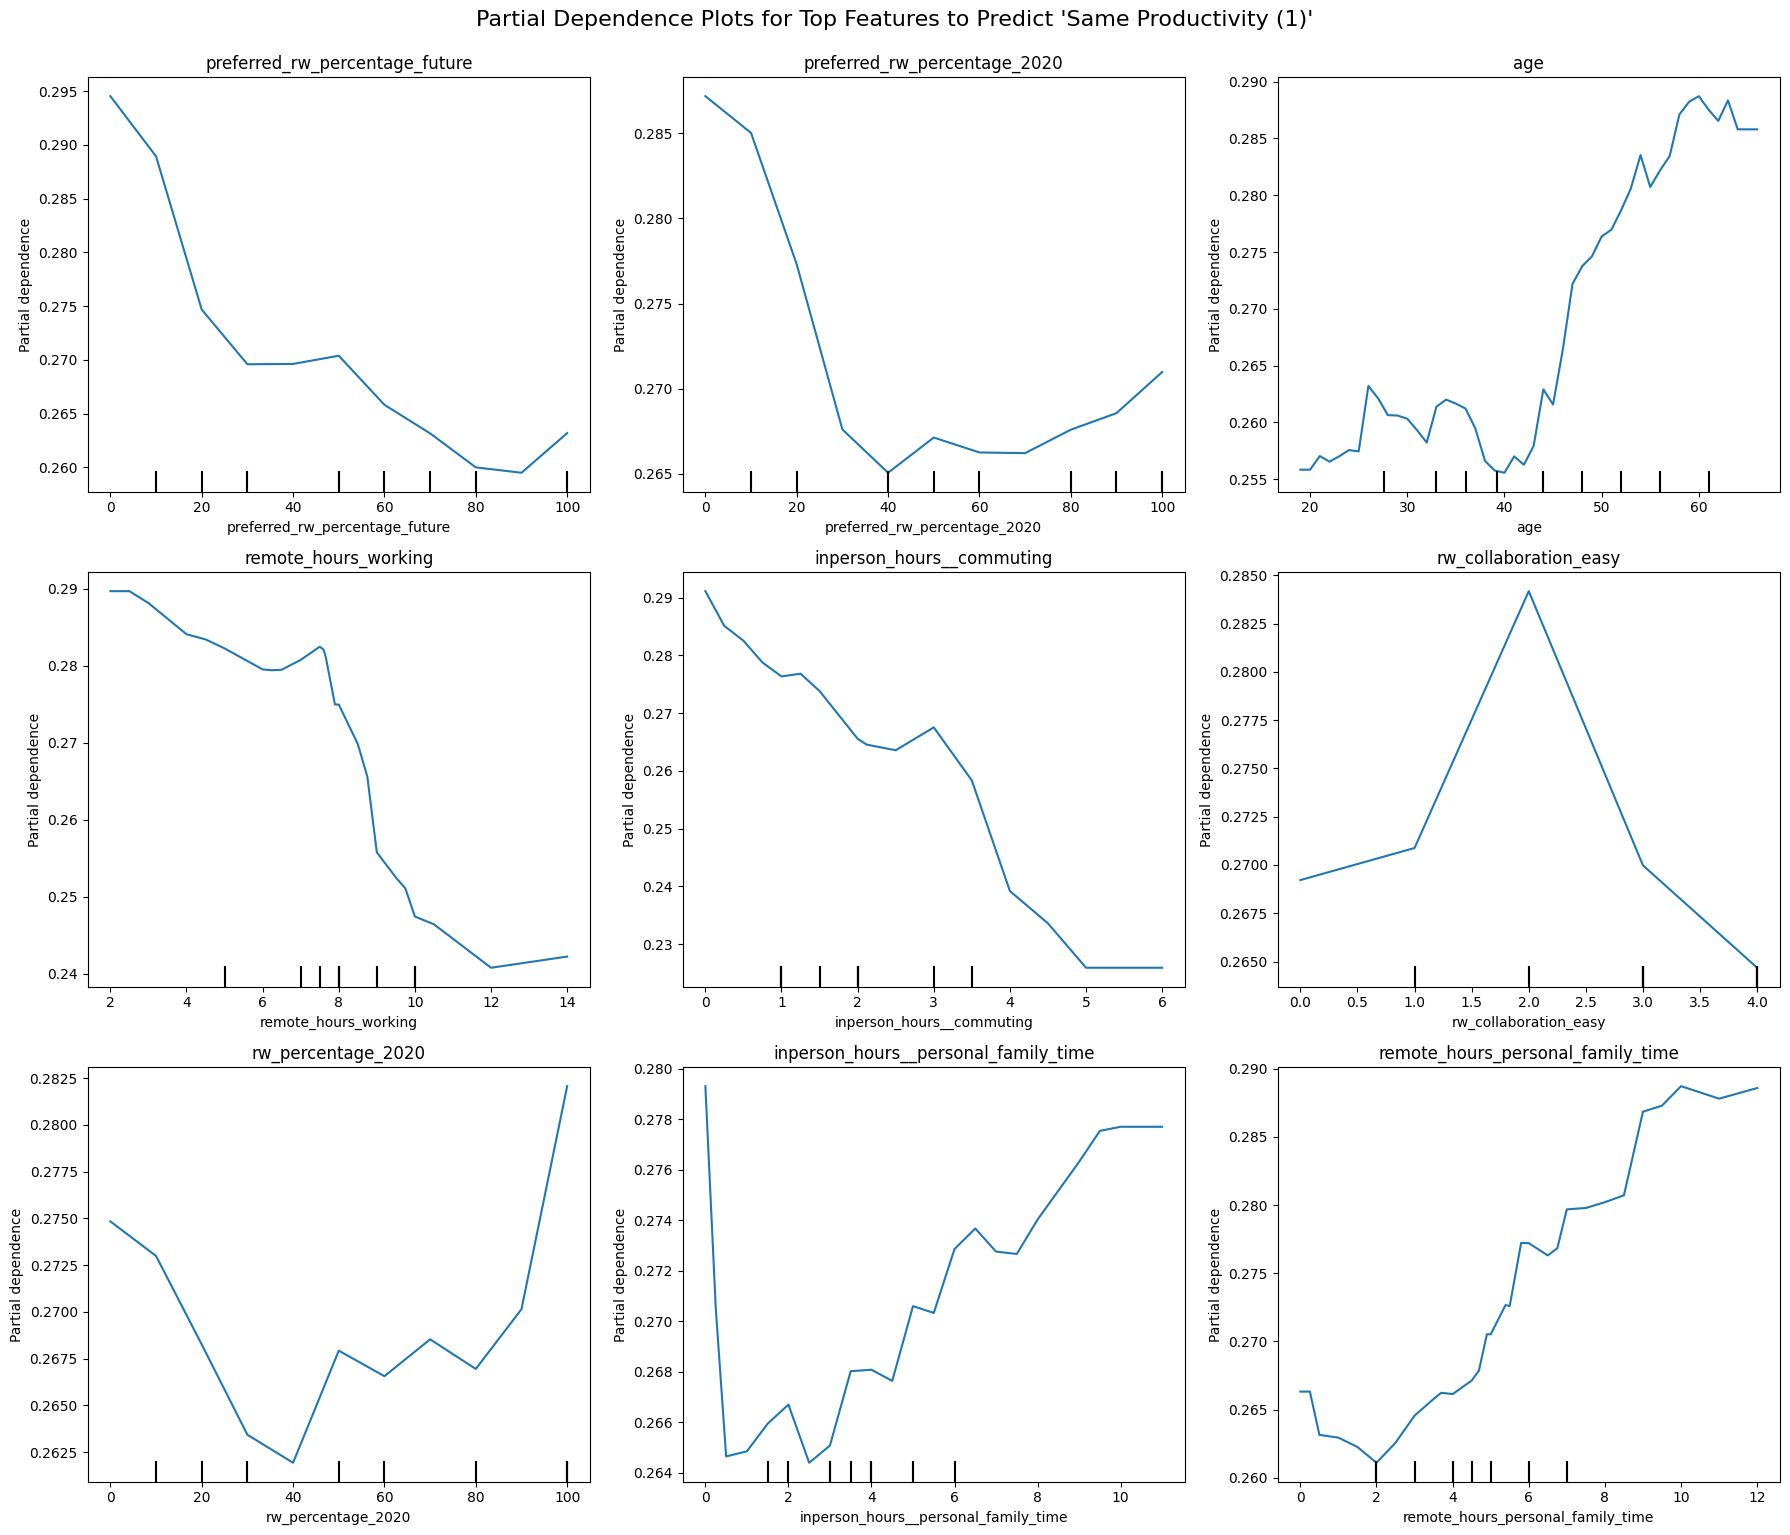

In [10]:
#Set the target class. 1 = Same Productivity
target_class = 1

# List of top features to analyze
top_features = feature_importance_df['Feature'][:9]

# Create a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Generate Partial Dependence Display for each feature in the grid
for idx, feature in enumerate(top_features):
    row, col = divmod(idx, 3) 
    PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_test,
        features=[feature],
        target=target_class,
        ax=axes[row, col],
    )
    axes[row, col].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.suptitle("Partial Dependence Plots for Top Features to Predict 'Same Productivity (1)'", y=1.02, fontsize=16)
plt.show()

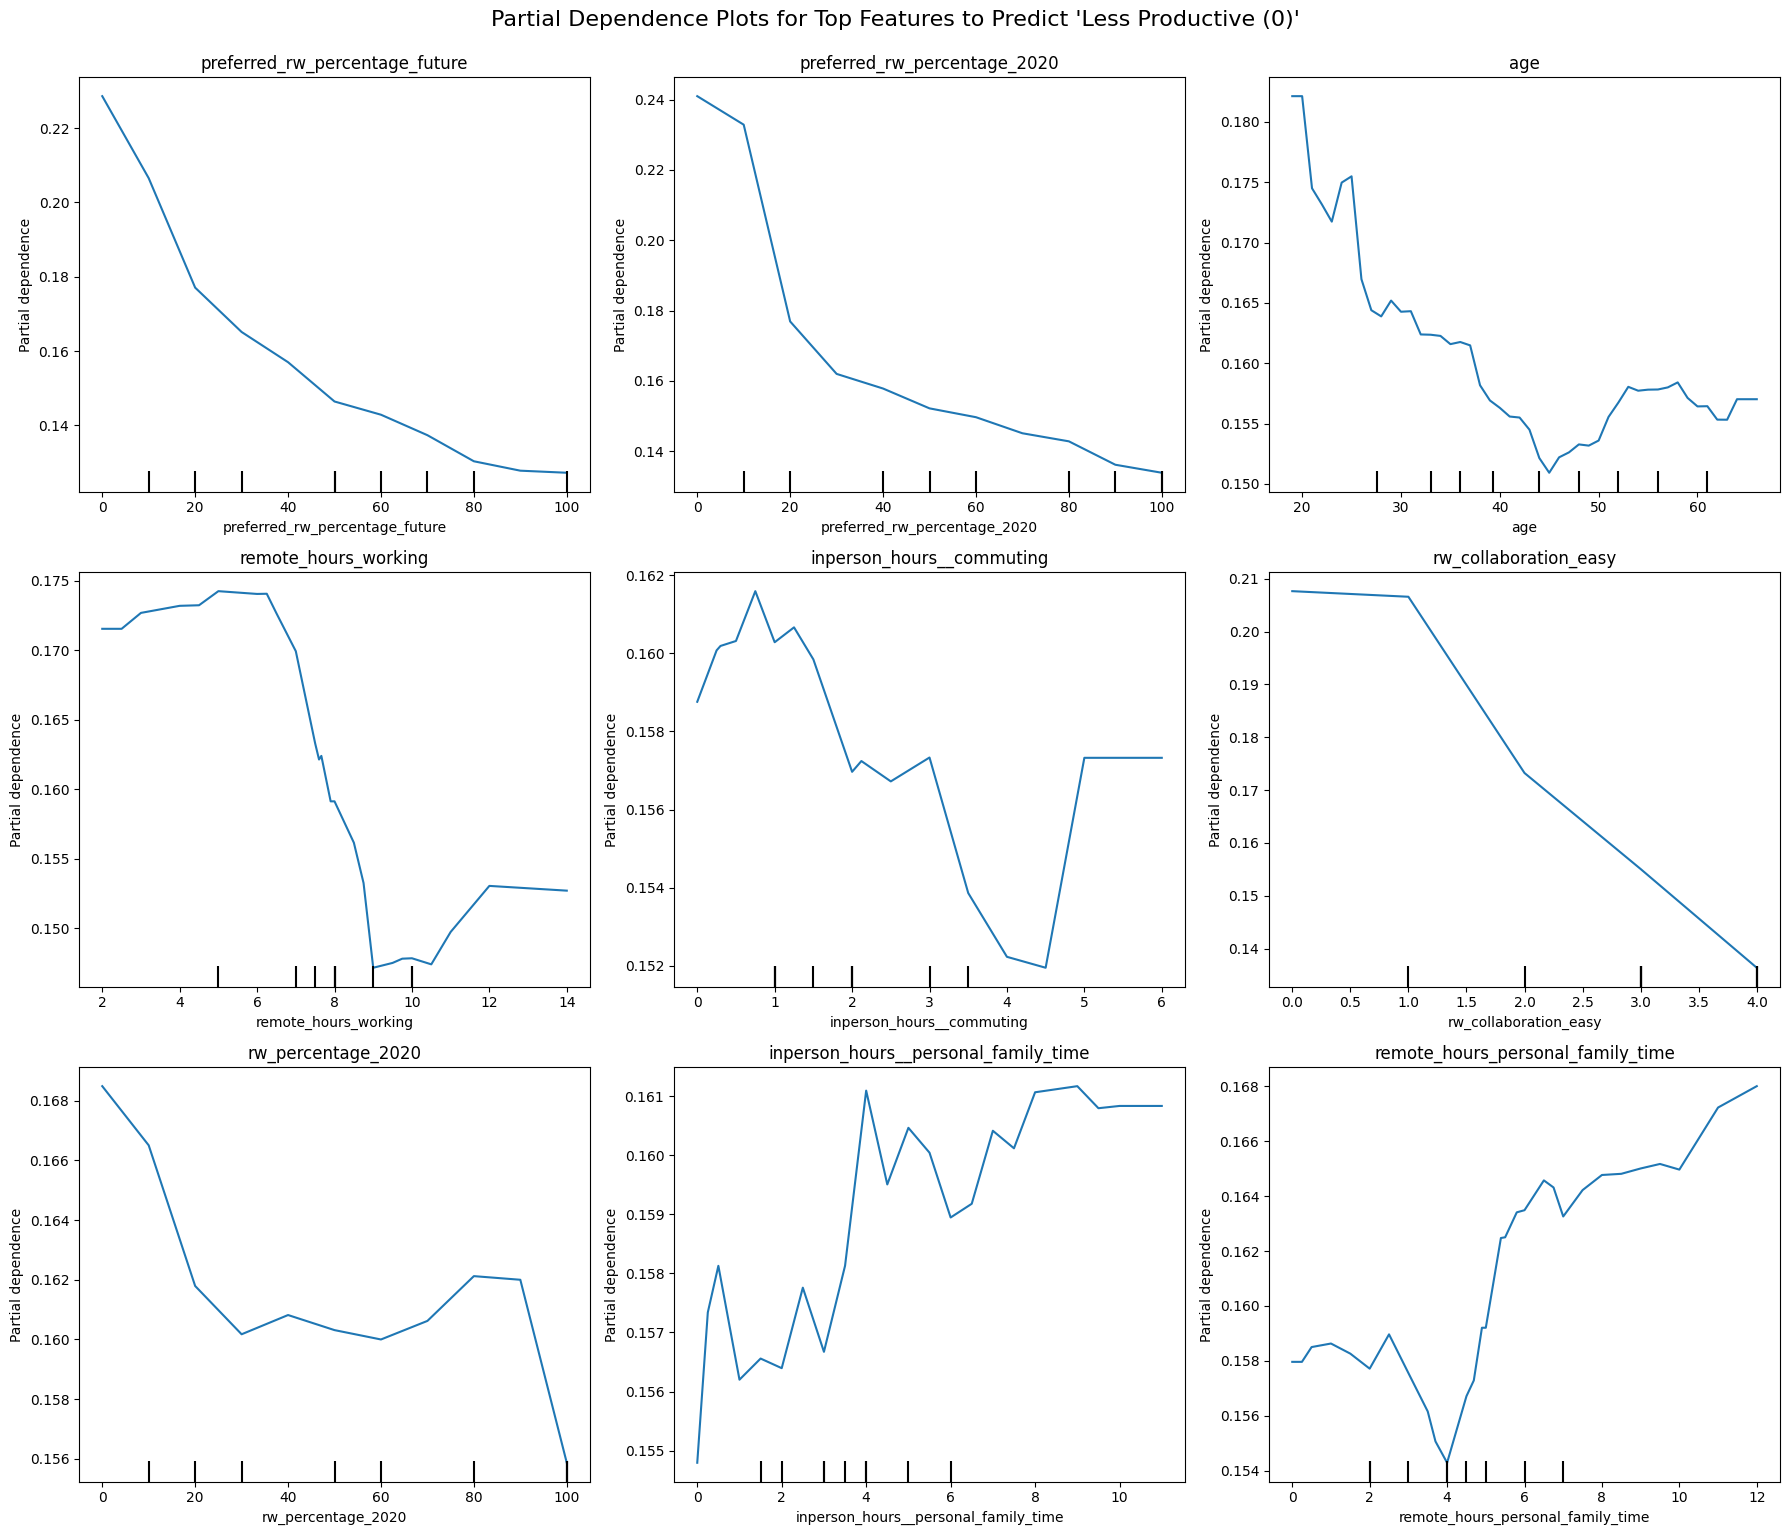

In [11]:
#Set the target class. 0 = Less Productive
target_class = 0

# List of top features to analyze
top_features = feature_importance_df['Feature'][:9]

# Create a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Generate Partial Dependence Display for each feature in the grid
for idx, feature in enumerate(top_features):
    row, col = divmod(idx, 3) 
    PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_test,
        features=[feature],
        target=target_class,
        ax=axes[row, col],
    )
    axes[row, col].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.suptitle("Partial Dependence Plots for Top Features to Predict 'Less Productive (0)'", y=1.02, fontsize=16)
plt.show()

## Partial Dependence Plots by Occupation

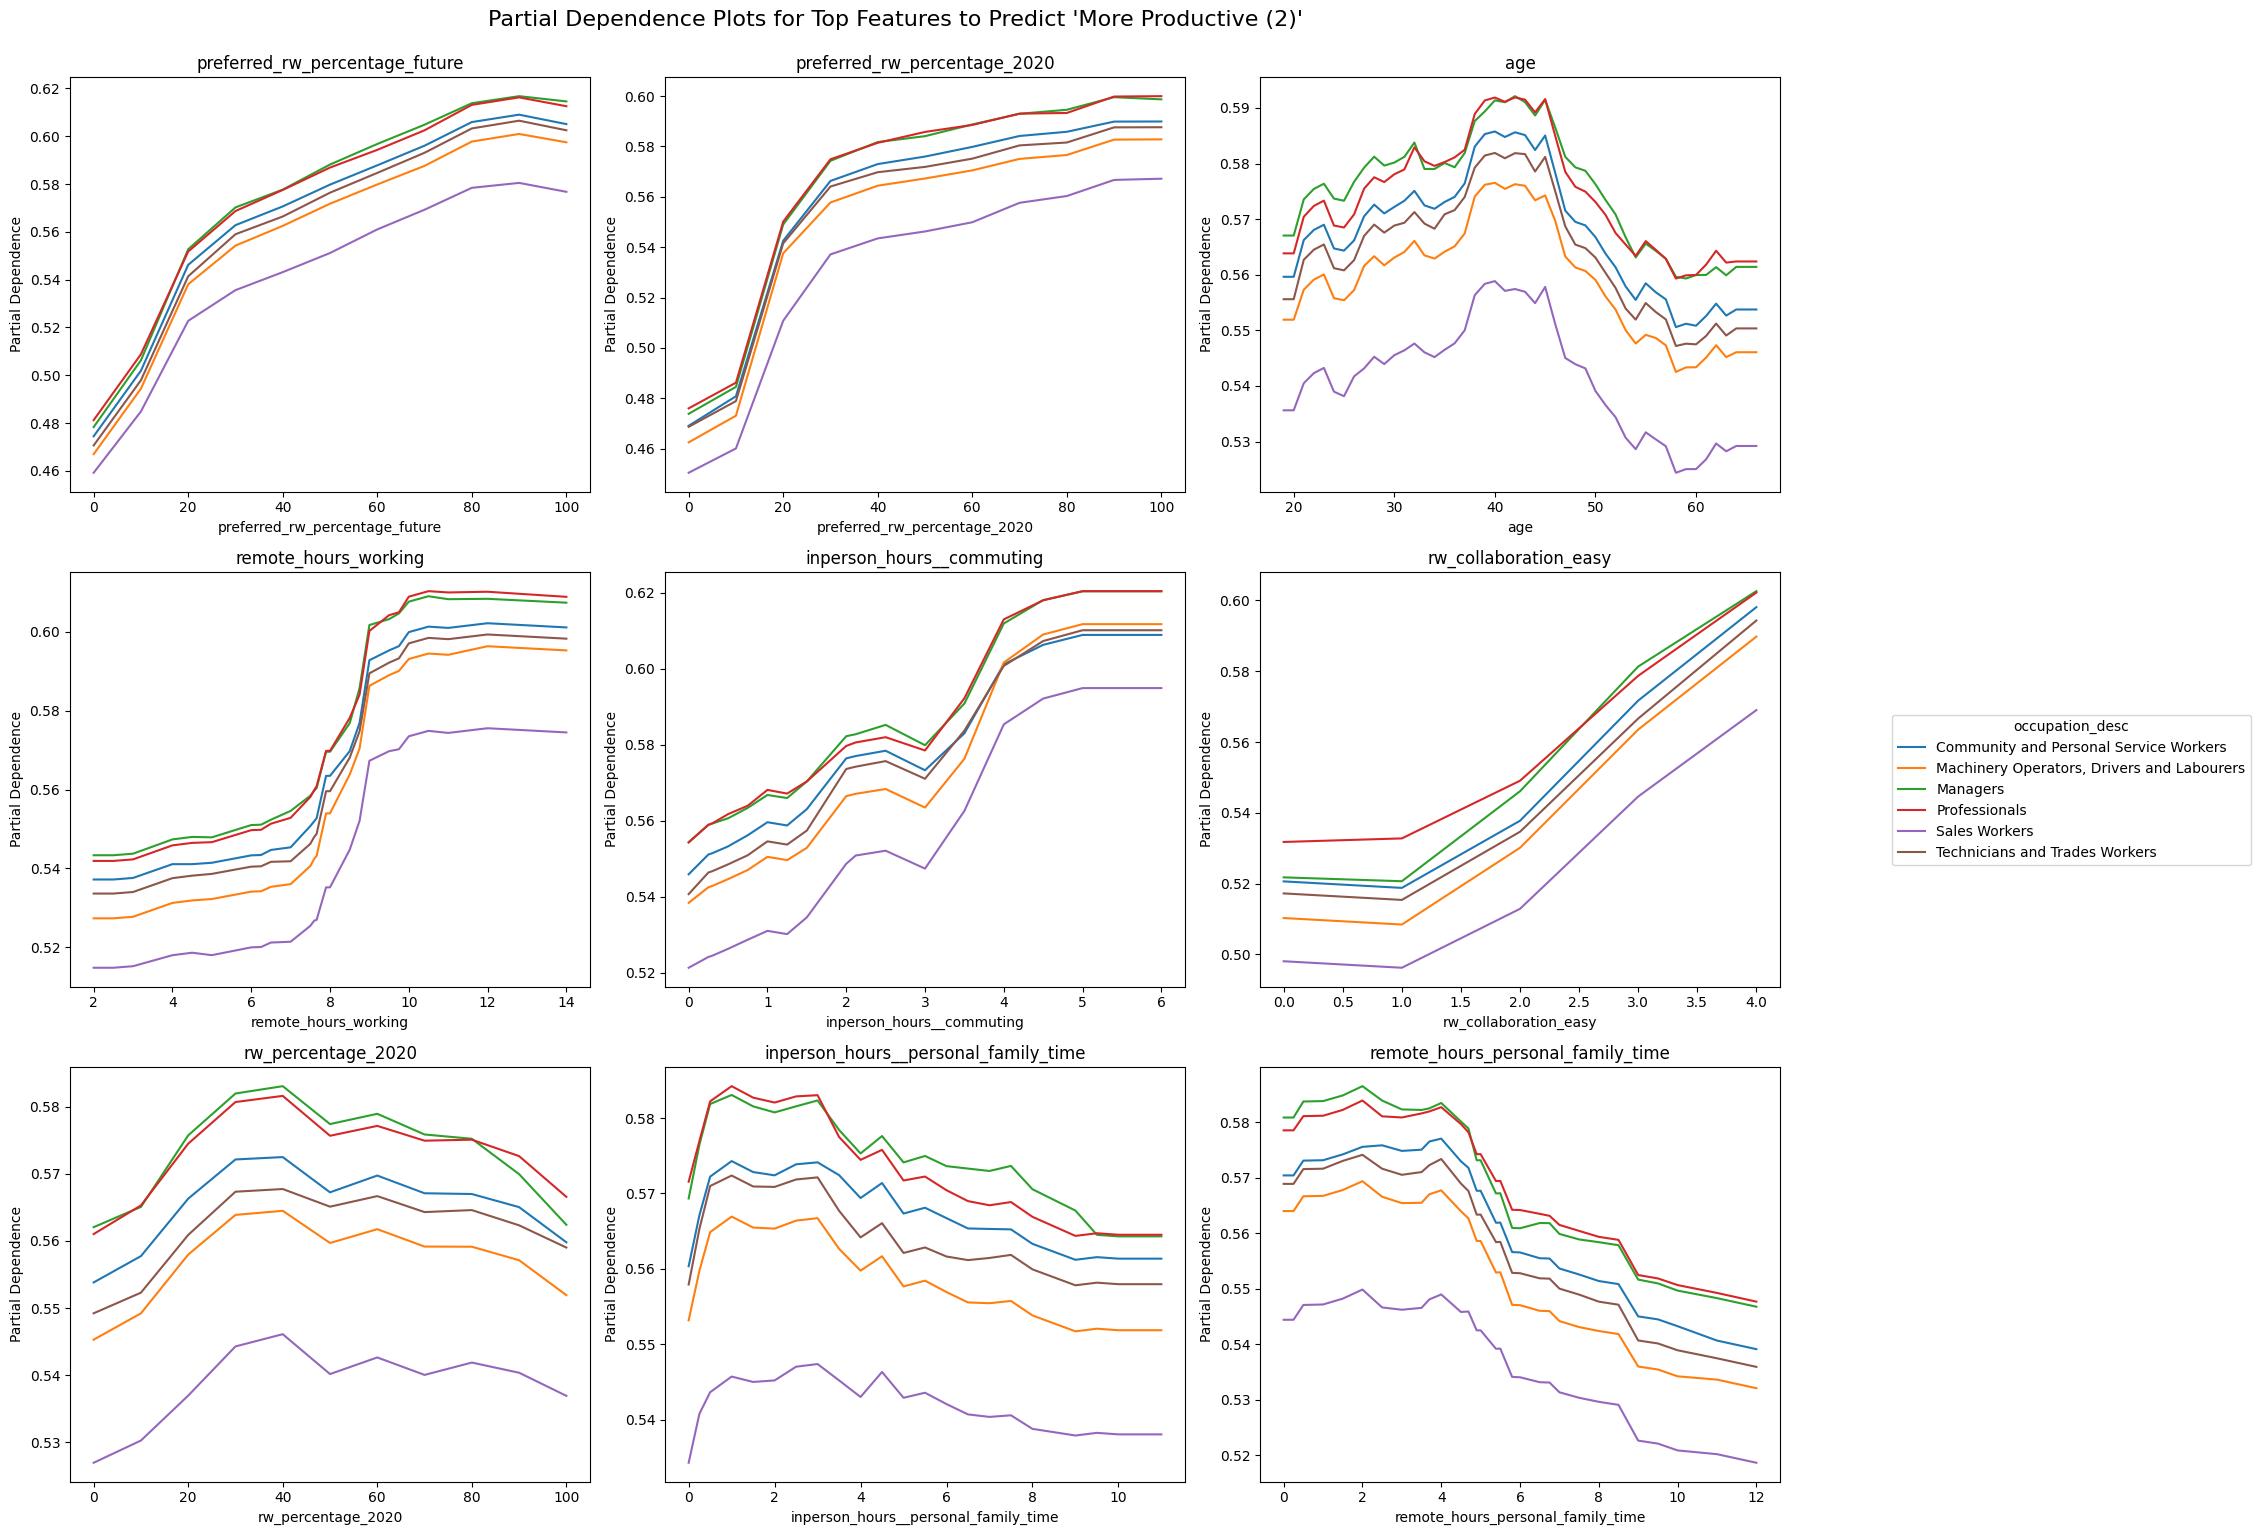

In [12]:
# Top features based on feature importance
top_features = feature_importance_df['Feature'][:9]

# Extract columns corresponding to 'occupation_desc' after one-hot encoding
occupation_columns = [col for col in X_test.columns if 'occupation_desc' in col]

# Set the target index for partial dependence (e.g., 2 for "more productive")
target_index = list(best_rf_model.classes_).index(2)  # Get index for class 2 ("more productive")

# Create a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten() 

# Loop through the top features and plot in the grid
for idx, feature in enumerate(top_features):
    ax = axes[idx]
    ax.set_title(feature)

    # Loop through each unique value of 'occupation_desc'
    for occupation in occupation_columns:
        # Create a modified dataset conditioned on the specific occupation
        conditioned_data = X_test.copy()
        conditioned_data[occupation_columns] = 0  
        conditioned_data[occupation] = 1 

        # Compute the partial dependence
        pd_results = partial_dependence(
            estimator=best_rf_model,
            X=conditioned_data,
            features=[feature],
            response_method='auto',
        )

        # Extract PDP results
        pd_values = pd_results['average'][target_index]
        feature_values = pd_results['grid_values'][0]

        # Plot PDP line for the current occupation
        ax.plot(feature_values, pd_values, label=occupation.replace('occupation_desc_', ''))

    # Add labels
    ax.set_xlabel(feature)
    ax.set_ylabel("Partial Dependence")

# Add a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="occupation_desc", bbox_to_anchor=(1.05, 0.5), loc='center left')

# Adjust layout
plt.tight_layout()
plt.suptitle("Partial Dependence Plots for Top Features to Predict 'More Productive (2)'", y=1.02, fontsize=16)
plt.show()

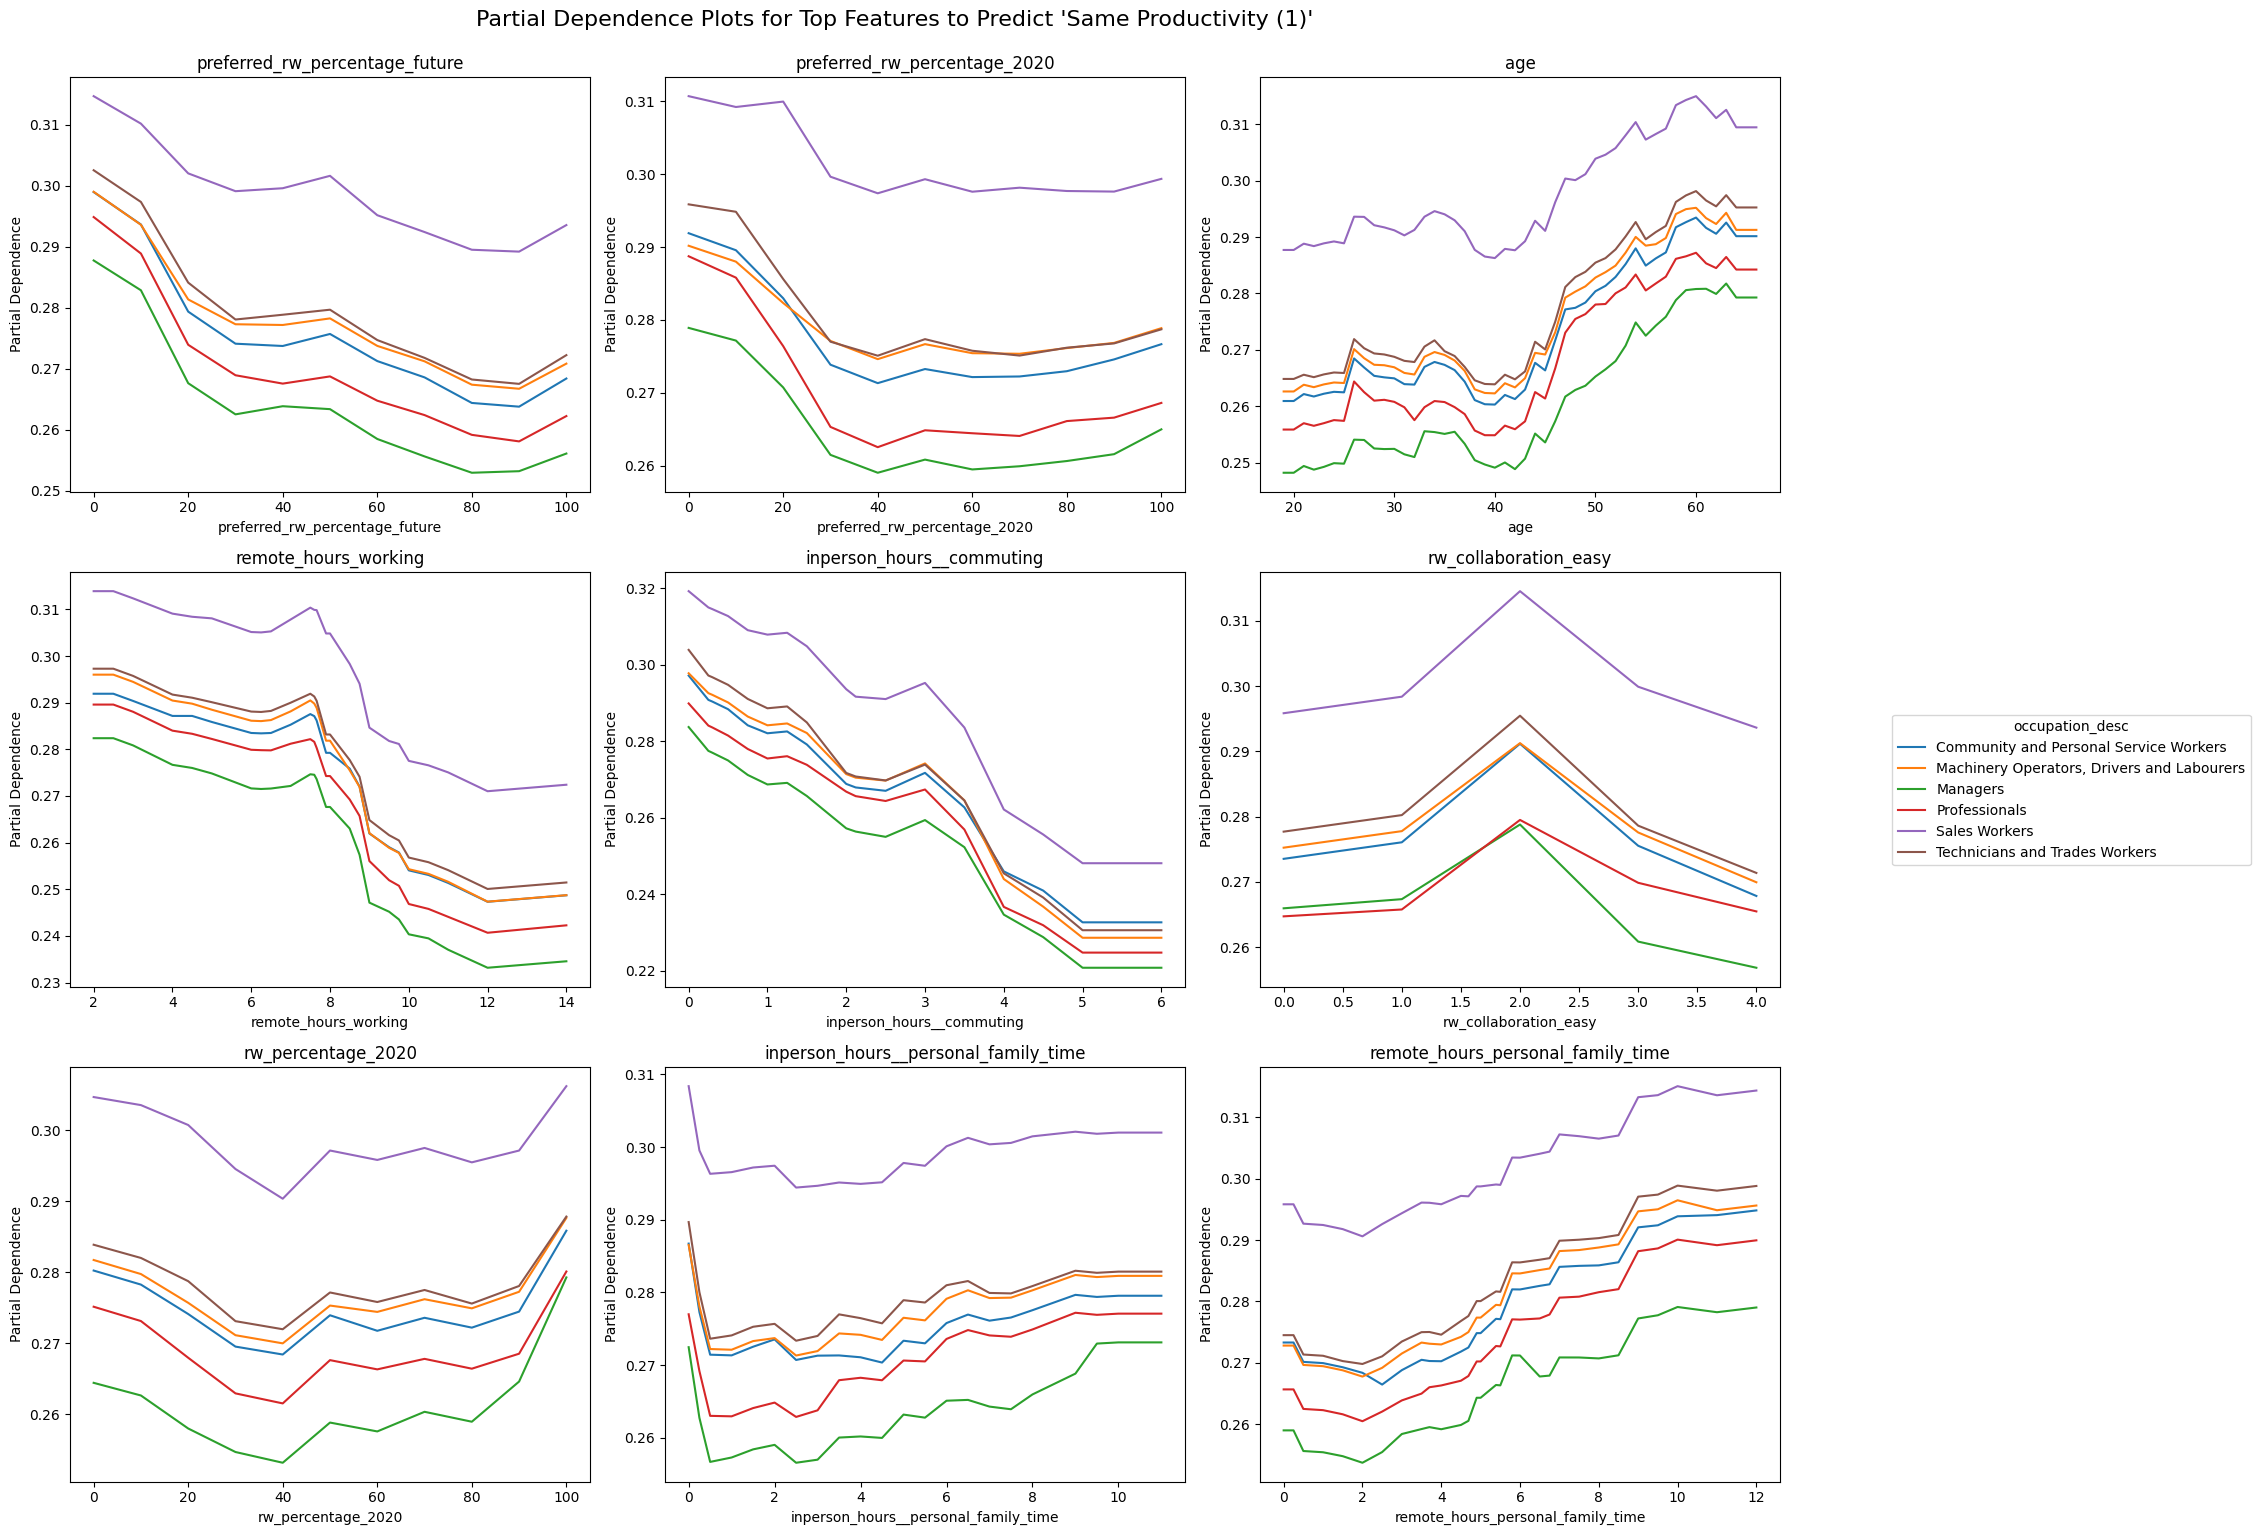

In [13]:
# Top features based on feature importance
top_features = feature_importance_df['Feature'][:9]

# Extract columns corresponding to 'occupation_desc' after one-hot encoding
occupation_columns = [col for col in X_test.columns if 'occupation_desc' in col]

# Set the target index for partial dependence (e.g., 1 for "same productivity")
target_index = list(best_rf_model.classes_).index(1)  # Get index for class 1 ("same productivity")

# Create a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through the top features and plot in the grid
for idx, feature in enumerate(top_features):
    ax = axes[idx]
    ax.set_title(feature)

    # Loop through each unique value of 'occupation_desc'
    for occupation in occupation_columns:
        # Create a modified dataset conditioned on the specific occupation
        conditioned_data = X_test.copy()
        conditioned_data[occupation_columns] = 0  # Set all occupation_desc columns to 0
        conditioned_data[occupation] = 1  # Set the specific occupation to active

        # Compute the partial dependence
        pd_results = partial_dependence(
            estimator=best_rf_model,
            X=conditioned_data,
            features=[feature],
            response_method='auto',  # Adjust automatically to the model
        )

        # Extract PDP results
        pd_values = pd_results['average'][target_index]
        feature_values = pd_results['grid_values'][0]

        # Plot PDP line for the current occupation
        ax.plot(feature_values, pd_values, label=occupation.replace('occupation_desc_', ''))

    # Add labels
    ax.set_xlabel(feature)
    ax.set_ylabel("Partial Dependence")

# Add a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="occupation_desc", bbox_to_anchor=(1.05, 0.5), loc='center left')

# Adjust layout
plt.tight_layout()
plt.suptitle("Partial Dependence Plots for Top Features to Predict 'Same Productivity (1)'", y=1.02, fontsize=16)
plt.show()

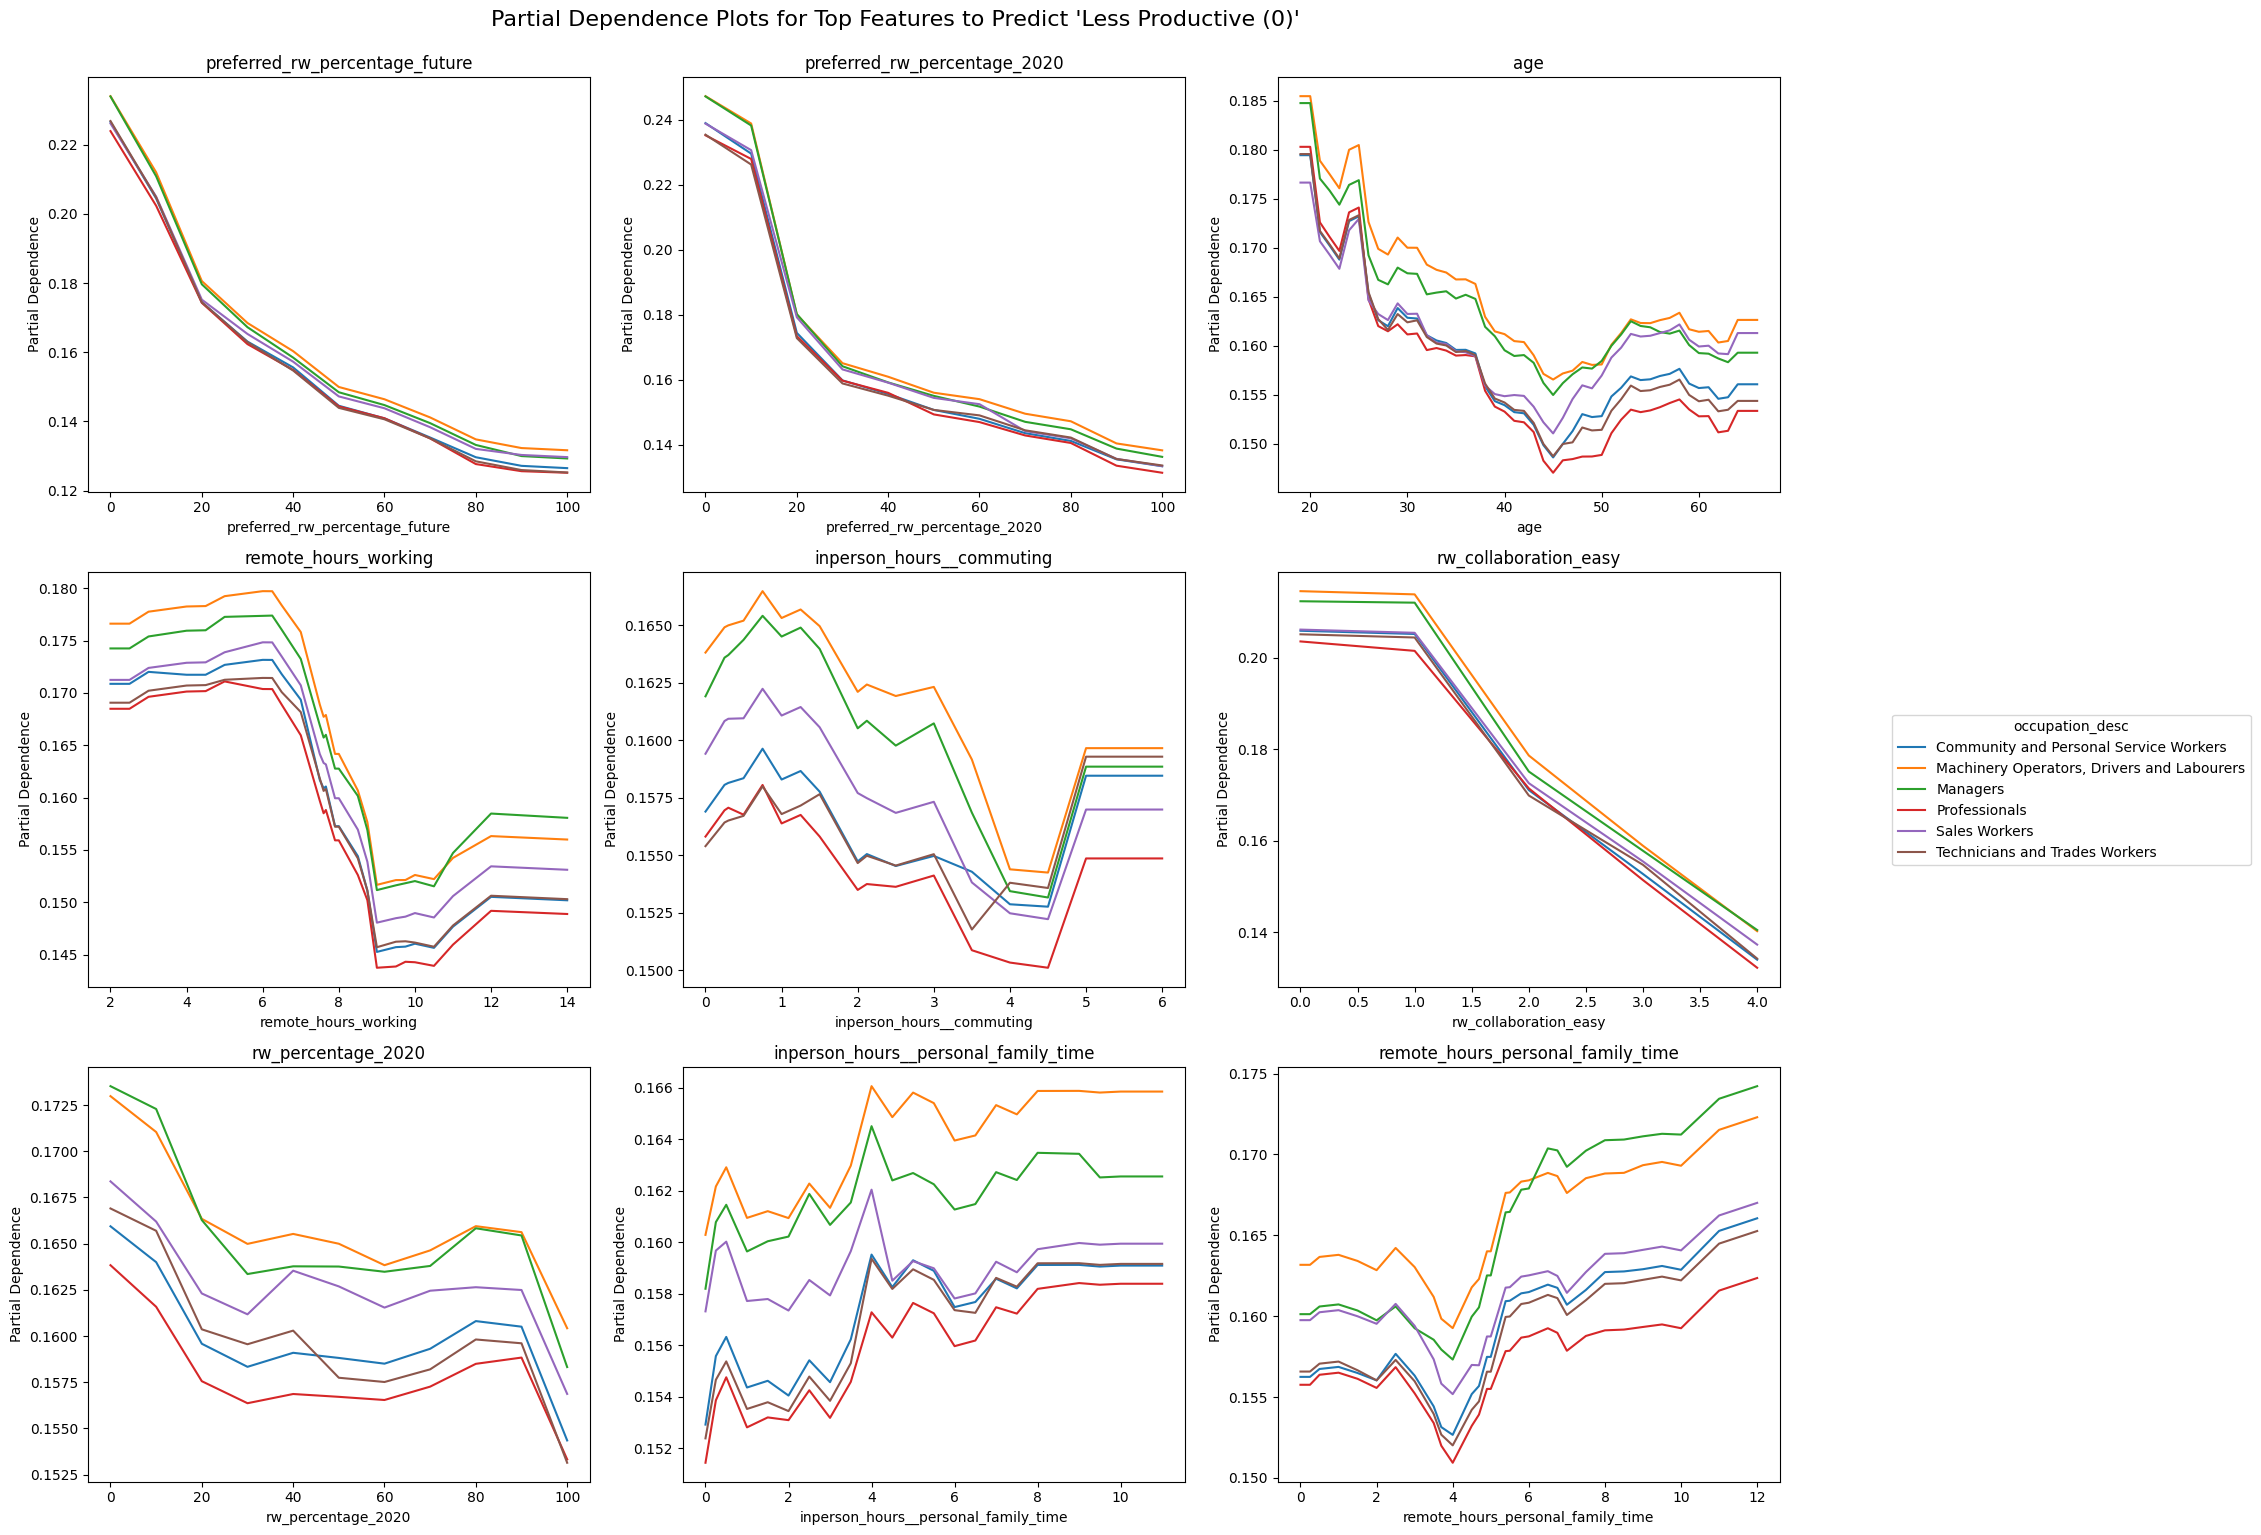

In [14]:
# Top features based on feature importance
top_features = feature_importance_df['Feature'][:9]

# Extract columns corresponding to 'occupation_desc' after one-hot encoding
occupation_columns = [col for col in X_test.columns if 'occupation_desc' in col]

# Set the target index for partial dependence (e.g., 0 for "less productive")
target_index = list(best_rf_model.classes_).index(0)  # Get index for class 0 ("less productive")

# Create a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Loop through the top features and plot in the grid
for idx, feature in enumerate(top_features):
    ax = axes[idx]
    ax.set_title(feature)

    # Loop through each unique value of 'occupation_desc'
    for occupation in occupation_columns:
        # Create a modified dataset conditioned on the specific occupation
        conditioned_data = X_test.copy()
        conditioned_data[occupation_columns] = 0  
        conditioned_data[occupation] = 1  

        # Compute the partial dependence
        pd_results = partial_dependence(
            estimator=best_rf_model,
            X=conditioned_data,
            features=[feature],
            response_method='auto',  
        )

        # Extract PDP results
        pd_values = pd_results['average'][target_index]
        feature_values = pd_results['grid_values'][0]

        # Plot PDP line for the current occupation
        ax.plot(feature_values, pd_values, label=occupation.replace('occupation_desc_', ''))

    # Add labels
    ax.set_xlabel(feature)
    ax.set_ylabel("Partial Dependence")

# Add a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="occupation_desc", bbox_to_anchor=(1.05, 0.5), loc='center left')

# Adjust layout
plt.tight_layout()
plt.suptitle("Partial Dependence Plots for Top Features to Predict 'Less Productive (0)'", y=1.02, fontsize=16)
plt.show()